# Sessão 1: Configuração e Carregamento do Dataset Processado
<div class="markdown">
Vamos começar carregando o dataset que preparamos no notebook anterior (02_Engenharia_de_Caracteristicas). Este será o nosso ponto de partida. O notebook 02 deve ser executado primeiro para que o X_encoded e o y estejam disponíveis.
</div>

In [9]:
import joblib
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, precision_recall_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping 
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

In [10]:
X_encoded = pd.read_csv('../data/X_encoded.csv')
y = pd.read_csv('../data/y.csv')

# Sessão 2: Divisão dos Dados em Conjuntos de Treino e Teste
<div class="markdown">
Este é um passo fundamental em qualquer projeto de machine learning. Nós dividimos nosso dataset em dois: um conjunto de treino, que o modelo usará para aprender os padrões, e um conjunto de teste, que o modelo nunca viu antes. Usamos o conjunto de teste para avaliar o quão bem o modelo generaliza para novos dados. Isso nos protege do overfitting, onde o modelo apenas decora os dados de treino em vez de aprender de verdade.   


</div>

In [11]:
# Separação por temporada (mais realista que split aleatório)
# Treino: temporadas 2022-23 e 2023-24
# Teste: temporada 2024-25

# Verificar se a coluna season existe
if 'season' in X_encoded.columns:
    # Separar por temporada
    train_seasons = ['2022-23', '2023-24']
    test_season = ['2024-25']
    
    # Criar máscaras para treino e teste
    train_mask = X_encoded['season'].isin(train_seasons)
    test_mask = X_encoded['season'].isin(test_season)
    
    # Aplicar as máscaras
    X_train = X_encoded[train_mask].copy()
    X_test = X_encoded[test_mask].copy()
    y_train = y[train_mask].copy()
    y_test = y[test_mask].copy()
    
    print("Dados divididos por temporada:")
    print(f"Temporadas de treino: {train_seasons}")
    print(f"Temporada de teste: {test_season}")
    print(f"Tamanho do treino (X_train): {X_train.shape}")
    print(f"Tamanho do teste (X_test): {X_test.shape}")
    
    # Verificar distribuição das temporadas
    print(f"\nDistribuição por temporada no treino:")
    print(X_train['season'].value_counts())
    print(f"\nDistribuição por temporada no teste:")
    print(X_test['season'].value_counts())
    
else:
    print("Coluna 'season' não encontrada. Usando split aleatório como fallback.")
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, 
        y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    print("Dados divididos em conjuntos de treino e teste:")
    print(f"Tamanho do treino (X_train): {X_train.shape}")
    print(f"Tamanho do teste (X_test): {X_test.shape}")

Coluna 'season' não encontrada. Usando split aleatório como fallback.
Dados divididos em conjuntos de treino e teste:
Tamanho do treino (X_train): (524357, 71)
Tamanho do teste (X_test): (131090, 71)


In [12]:
X_test.to_csv('../data/X_test_id.csv', index=False)
y_test.to_csv('../data/y_test_id.csv', index=False)

In [13]:
# Remover colunas de ID e season (não usadas no treinamento)
columns_to_drop = ['game_id', 'player_id', 'team_id']
if 'season' in X_train.columns:
    columns_to_drop.append('season')

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

print(f"Colunas removidas: {columns_to_drop}")
print(f"Features finais para treinamento: {X_train.shape[1]}")

Colunas removidas: ['game_id', 'player_id', 'team_id']
Features finais para treinamento: 68


# Sessão 3: Treinamento do Modelo XGBoost
<div class="markdown">
Agora, vamos treinar nosso modelo. Escolhemos o XGBoost (eXtreme Gradient Boosting) porque ele é um dos algoritmos mais poderosos e de melhor desempenho para dados tabulares, como o nosso. Ele consistentemente vence competições de machine learning e é amplamente utilizado na indústria para problemas de classificação. O processo de    

fit é onde o modelo analisa os dados de treino (X_train, y_train) e aprende as relações entre as características e o resultado do arremesso.
</div>

In [14]:
# Inicializar o classificador XGBoost
# Usamos alguns parâmetros básicos para começar:
# n_estimators: número de "árvores" que o modelo vai construir.
# max_depth: a profundidade máxima de cada árvore.
# learning_rate: controla o quão rápido o modelo aprende.
# objective='binary:logistic': informa ao modelo que este é um problema de classificação binária.
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

print("Iniciando o treinamento do modelo XGBoost...")

# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

print("Treinamento concluído!")

Iniciando o treinamento do modelo XGBoost...
Treinamento concluído!


# Sessão 4: Avaliação do Desempenho do Modelo
<div class="markdown">
Com o modelo treinado, é hora da verdade. Vamos usar o conjunto de teste (X_test), que o modelo nunca viu, para fazer previsões e comparar com os resultados reais (y_test). Analisaremos a performance usando três ferramentas principais:

Acurácia (Accuracy): A métrica mais simples. Qual a porcentagem de arremessos que o modelo acertou?

Matriz de Confusão (Confusion Matrix): Uma tabela que nos mostra os tipos de acertos e erros do modelo (Verdadeiros Positivos, Falsos Positivos, etc.).

Relatório de Classificação (Classification Report): Fornece métricas mais detalhadas como Precisão, Recall e F1-Score, que são mais robustas, especialmente para entender o desempenho em cada classe (convertidos vs. errados).   


</div>

Acurácia do Modelo: 63.25%

Relatório de Classificação:
                precision    recall  f1-score   support

    Errado (0)       0.61      0.84      0.71     69177
Convertido (1)       0.69      0.40      0.50     61913

      accuracy                           0.63    131090
     macro avg       0.65      0.62      0.61    131090
  weighted avg       0.65      0.63      0.61    131090


Matriz de Confusão:


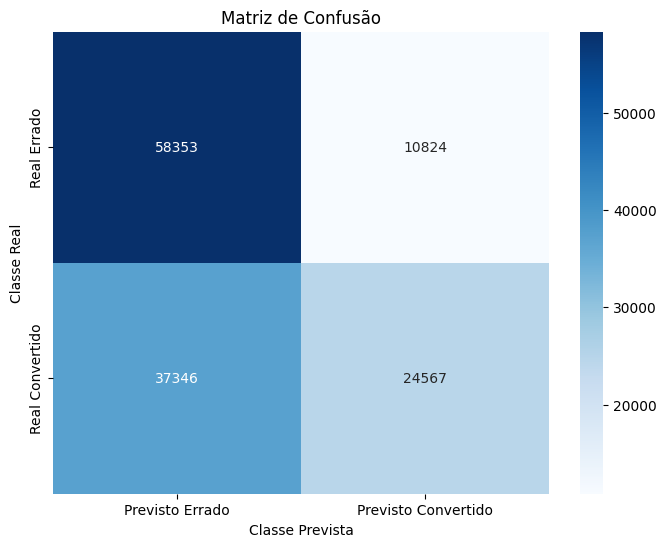

In [15]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# 1. Calcular a Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do Modelo: {accuracy:.2%}")

# 2. Gerar o Relatório de Classificação
print("\nRelatório de Classificação:")
# 'target_names' nos ajuda a rotular as classes 0 e 1 como 'Errado' e 'Convertido'
print(classification_report(y_test, y_pred, target_names=['Errado (0)', 'Convertido (1)']))

# 3. Visualizar a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto Errado', 'Previsto Convertido'],
            yticklabels=['Real Errado', 'Real Convertido'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# Otimização com RandomizedSearchCV
<div class="markdown">
Agora, a etapa de otimização. Definimos um espaço de busca de hiperparâmetros mais amplo e deixamos o RandomizedSearchCV explorar combinações aleatórias para encontrar um modelo de alta performance de forma eficiente. Otimizaremos para o f1_weighted para buscar um bom equilíbrio entre precisão e recall.   

Aviso: Este processo ainda é computacionalmente intensivo e pode levar alguns minutos.
</div>

In [16]:
# Definindo a grade de parâmetros para a busca aleatória
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Inicializar o RandomizedSearchCV
# n_iter=20: testará 20 combinações aleatórias
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    random_state=42
)

print("Iniciando a busca aleatória (Randomized Search)...")
random_search.fit(X_train, y_train)
print("Busca aleatória concluída!")

Iniciando a busca aleatória (Randomized Search)...
Busca aleatória concluída!


# Avaliação do Modelo Final Tunado
<div class="markdown">
Vamos analisar os resultados. Primeiro, veremos quais foram os melhores hiperparâmetros encontrados. Em seguida, usaremos o melhor modelo para fazer previsões no conjunto de teste e avaliaremos sua performance final. A expectativa é que, com as novas features e a otimização, tenhamos um modelo significativamente melhor.
</div>

Melhores hiperparâmetros encontrados:
{'subsample': 0.8, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Acurácia do Modelo Tunado: 63.18%

Relatório de Classificação do Modelo Tunado:
                precision    recall  f1-score   support

    Errado (0)       0.61      0.83      0.70     69177
Convertido (1)       0.68      0.42      0.52     61913

      accuracy                           0.63    131090
     macro avg       0.65      0.62      0.61    131090
  weighted avg       0.64      0.63      0.61    131090


Matriz de Confusão do Modelo Tunado:


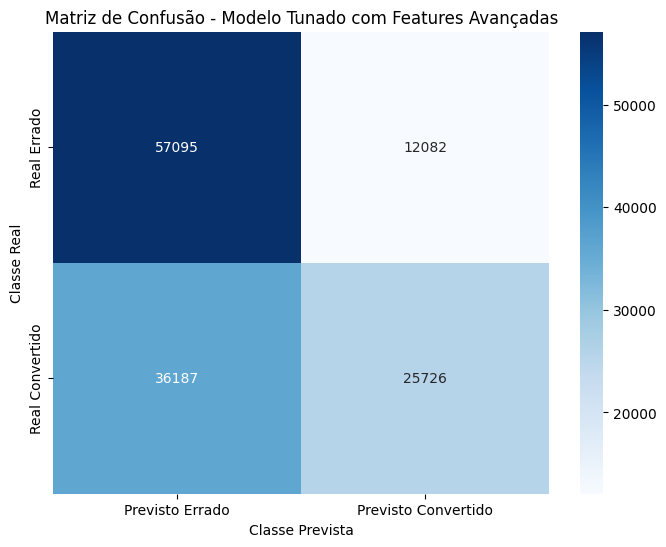

In [17]:
# Exibir os melhores parâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Usar o melhor modelo encontrado para fazer previsões
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)  # type: ignore

# Avaliar o modelo tunado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAcurácia do Modelo Tunado: {accuracy_tuned:.2%}")

print("\nRelatório de Classificação do Modelo Tunado:")
print(classification_report(y_test, y_pred_tuned, target_names=['Errado (0)', 'Convertido (1)']))

print("\nMatriz de Confusão do Modelo Tunado:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Errado', 'Previsto Convertido'],
            yticklabels=['Real Errado', 'Real Convertido'])
plt.title('Matriz de Confusão - Modelo Tunado com Features Avançadas')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# Otimizacão com RandomizedSearchCV

- Alterei scoring para neg_log_loss


In [18]:
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Inicializar o RandomizedSearchCV
# n_iter=20: testará 20 combinações aleatórias
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_log_loss',
    cv=3,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

print("Iniciando a busca aleatória (Randomized Search)...")
random_search.fit(X_train, y_train)
print("Busca aleatória concluída!")

Iniciando a busca aleatória (Randomized Search)...
Busca aleatória concluída!


# Avaliacão

Melhores hiperparâmetros encontrados:
{'subsample': 0.9, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}

Acurácia do Modelo Tunado: 63.29%

Relatório de Classificação do Modelo Tunado:
                precision    recall  f1-score   support

    Errado (0)       0.61      0.84      0.71     69177
Convertido (1)       0.69      0.41      0.51     61913

      accuracy                           0.63    131090
     macro avg       0.65      0.62      0.61    131090
  weighted avg       0.65      0.63      0.61    131090


Matriz de Confusão do Modelo Tunado:


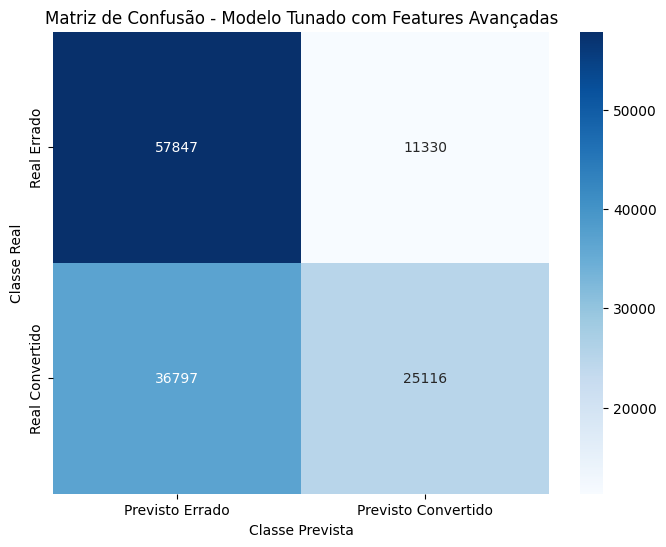

In [19]:
# Exibir os melhores parâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Usar o melhor modelo encontrado para fazer previsões
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)  # type: ignore

# Avaliar o modelo tunado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAcurácia do Modelo Tunado: {accuracy_tuned:.2%}")

print("\nRelatório de Classificação do Modelo Tunado:")
print(classification_report(y_test, y_pred_tuned, target_names=['Errado (0)', 'Convertido (1)']))

print("\nMatriz de Confusão do Modelo Tunado:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Errado', 'Previsto Convertido'],
            yticklabels=['Real Errado', 'Real Convertido'])
plt.title('Matriz de Confusão - Modelo Tunado com Features Avançadas')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# Otimizacão com RandomizedSearchCV

- Alterei n_iter, cv e param_dist

In [20]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 1.0), # 0.6 a 1.0
    'colsample_bytree': uniform(0.6, 1.0), # 0.6 a 1.0
    'gamma': uniform(0, 0.5)
}

# Inicializar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Inicializar o RandomizedSearchCV
# n_iter: número de combinações a testar. 50-100 é um bom começo.
# cv: número de folds para validação cruzada (essencial!)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

print("Iniciando a busca aleatória (Randomized Search)...")
random_search.fit(X_train, y_train)
print("Busca aleatória concluída!")

Iniciando a busca aleatória (Randomized Search)...


/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
375 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^

Busca aleatória concluída!


Melhores hiperparâmetros encontrados:
{'colsample_bytree': 0.7007780013774266, 'gamma': 0.009110912825774864, 'learning_rate': 0.038332888226778515, 'max_depth': 5, 'n_estimators': 826, 'subsample': 0.671188648460229}

Acurácia do Modelo Tunado: 63.28%

Relatório de Classificação do Modelo Tunado:
                precision    recall  f1-score   support

    Errado (0)       0.61      0.83      0.71     69177
Convertido (1)       0.69      0.41      0.51     61913

      accuracy                           0.63    131090
     macro avg       0.65      0.62      0.61    131090
  weighted avg       0.65      0.63      0.61    131090


Matriz de Confusão do Modelo Tunado:


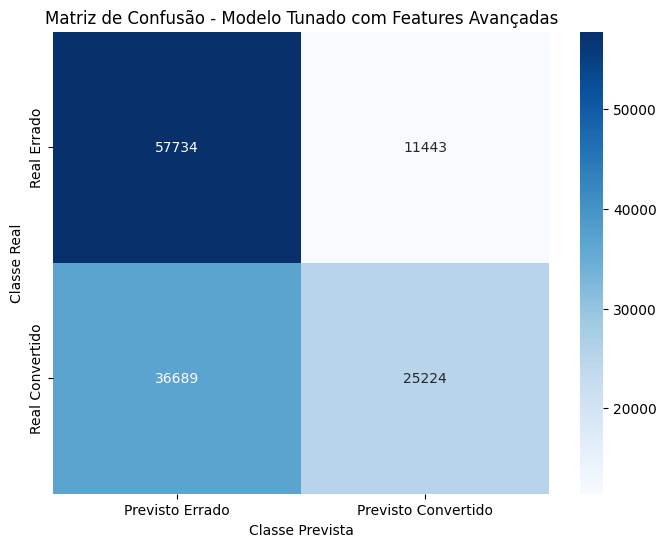

In [21]:
# Exibir os melhores parâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Usar o melhor modelo encontrado para fazer previsões
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)  # type: ignore

# Avaliar o modelo tunado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAcurácia do Modelo Tunado: {accuracy_tuned:.2%}")

print("\nRelatório de Classificação do Modelo Tunado:")
print(classification_report(y_test, y_pred_tuned, target_names=['Errado (0)', 'Convertido (1)']))

print("\nMatriz de Confusão do Modelo Tunado:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Errado', 'Previsto Convertido'],
            yticklabels=['Real Errado', 'Real Convertido'])
plt.title('Matriz de Confusão - Modelo Tunado com Features Avançadas')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

Recall (Errado - 0.83): O modelo é extremamente bom em identificar arremessos que serão errados. Ele capturou 83% de todos os erros no conjunto de teste.

Porem, para identificar arremessos certos, ele acerta somente 41%. Devido a isso, optamos pelo tratamento do desbalanceamento de classes, por mais que tenhamos uma perda na acuracia do modelo.

# Lidando com o Desbalanceamento de Classes

In [22]:
count_misses = (y_train == 0).sum()
count_makes = (y_train == 1).sum()
scale_pos_weight_value = float(count_misses / count_makes)

/var/folders/50/h8ysk4td5h51slcq00bhxfq80000gn/T/ipykernel_48096/1456943343.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scale_pos_weight_value = float(count_misses / count_makes)


In [23]:
scale_pos_weight_value

1.1173138113158787

In [24]:
param_dist = {
    'n_estimators': randint(100,1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4), # 0.6 a 1.0
    'colsample_bytree': uniform(0.6, 1.0), # 0.6 a 1.0
    'gamma': uniform(0, 0.5)
}

# Inicializar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1.35,
    random_state=42
)

# Inicializar o RandomizedSearchCV
# n_iter: número de combinações a testar. 50-100 é um bom começo.
# cv: número de folds para validação cruzada (essencial!)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

print("Iniciando a busca aleatória (Randomized Search)...")
random_search.fit(X_train, y_train)
print("Busca aleatória concluída!")

Iniciando a busca aleatória (Randomized Search)...


/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leonardomartini/Documents/github/MLET_FIAP_FASE3_NBA_ML_MODEL/venv/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^

Busca aleatória concluída!


Melhores hiperparâmetros encontrados:
{'colsample_bytree': 0.756437042671086, 'gamma': 0.12512144908229766, 'learning_rate': 0.17476799941183616, 'max_depth': 3, 'n_estimators': 587, 'subsample': 0.9738455989358838}

Acurácia do Modelo Tunado: 61.63%
Log Loss final no conjunto de teste: 0.6453

Relatório de Classificação do Modelo Tunado:
                precision    recall  f1-score   support

    Errado (0)       0.64      0.64      0.64     69177
Convertido (1)       0.59      0.59      0.59     61913

      accuracy                           0.62    131090
     macro avg       0.62      0.62      0.62    131090
  weighted avg       0.62      0.62      0.62    131090


Matriz de Confusão do Modelo Tunado:


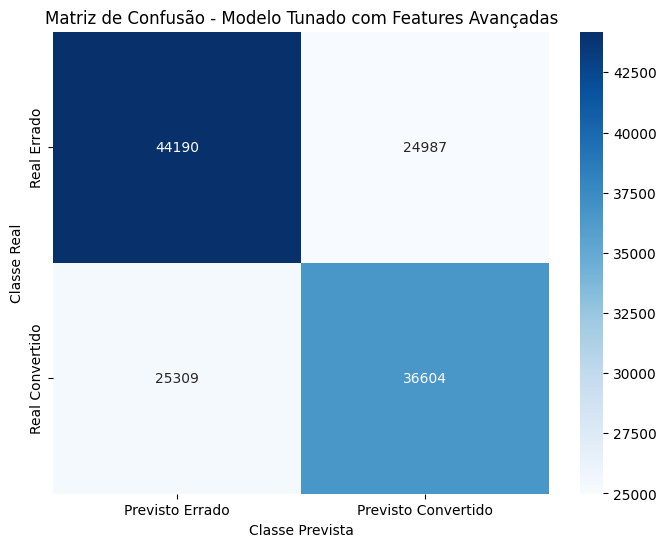

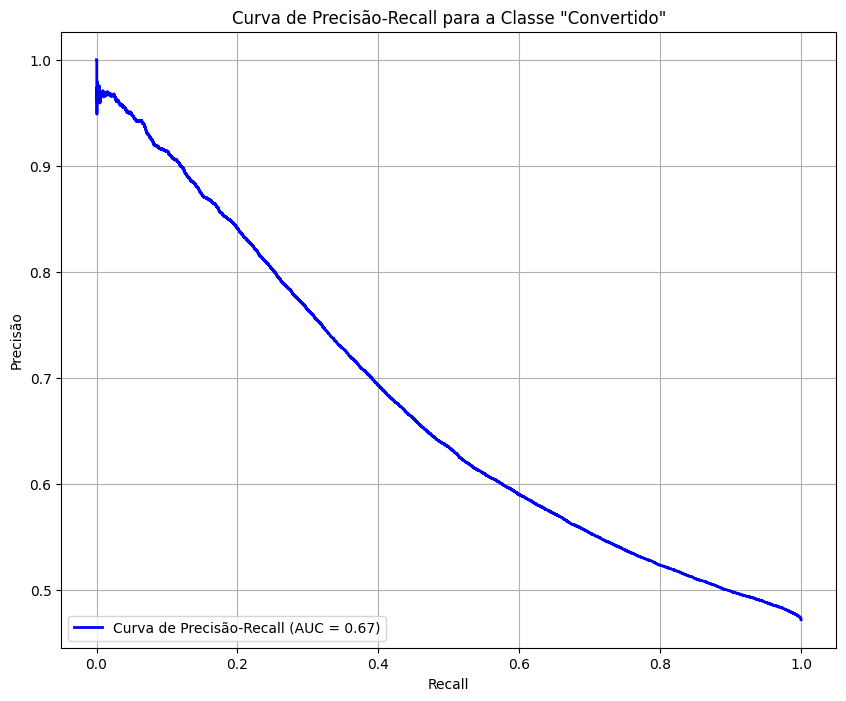

In [25]:
# Exibir os melhores parâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Usar o melhor modelo encontrado para fazer previsões
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)  # type: ignore
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo tunado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAcurácia do Modelo Tunado: {accuracy_tuned:.2%}")

final_logloss = log_loss(y_test, y_prob_tuned)
print(f"Log Loss final no conjunto de teste: {final_logloss:.4f}")

print("\nRelatório de Classificação do Modelo Tunado:")
print(classification_report(y_test, y_pred_tuned, target_names=['Errado (0)', 'Convertido (1)']))

print("\nMatriz de Confusão do Modelo Tunado:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Errado', 'Previsto Convertido'],
            yticklabels=['Real Errado', 'Real Convertido'])
plt.title('Matriz de Confusão - Modelo Tunado com Features Avançadas')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_tuned)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Curva de Precisão-Recall (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão-Recall para a Classe "Convertido"')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Calculando os Valores SHAP
<div class="markdown">
O próximo passo é criar um "explicador" (Explainer) do SHAP. Como estamos usando um modelo baseado em árvores (XGBoost), podemos usar o shap.TreeExplainer, que é altamente otimizado para este tipo de algoritmo. Em seguida, usaremos o explicador para calcular os valores SHAP para cada feature em nosso conjunto de teste. Este cálculo pode ser computacionalmente intensivo, então, para uma análise rápida, vamos usar uma amostra do nosso conjunto de teste.
</div>

In [26]:
# 1. Criar o explainer do SHAP
explainer = shap.TreeExplainer(best_model)

# 2. Calcular os valores SHAP para o conjunto de teste
# Usamos uma amostra para acelerar o processo de visualização
X_test_sample = X_test.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print("Valores SHAP calculados com sucesso para 1000 amostras do conjunto de teste.")

Valores SHAP calculados com sucesso para 1000 amostras do conjunto de teste.


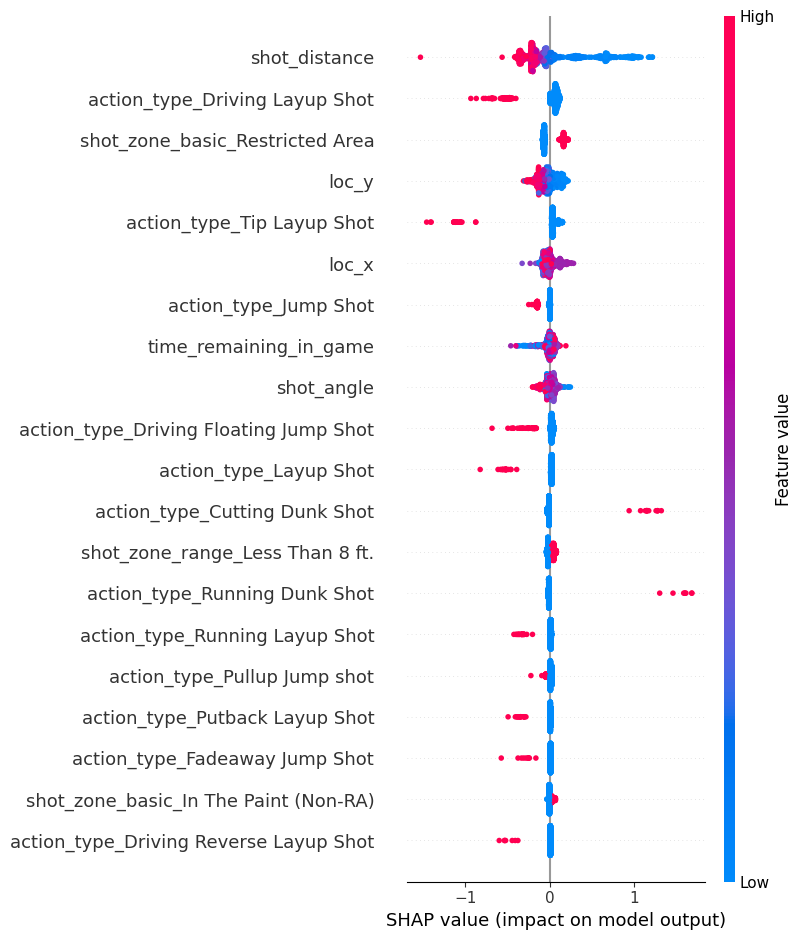

In [27]:
# Gerar o gráfico de resumo (beeswarm plot)
shap.summary_plot(shap_values, X_test_sample, plot_type="dot")

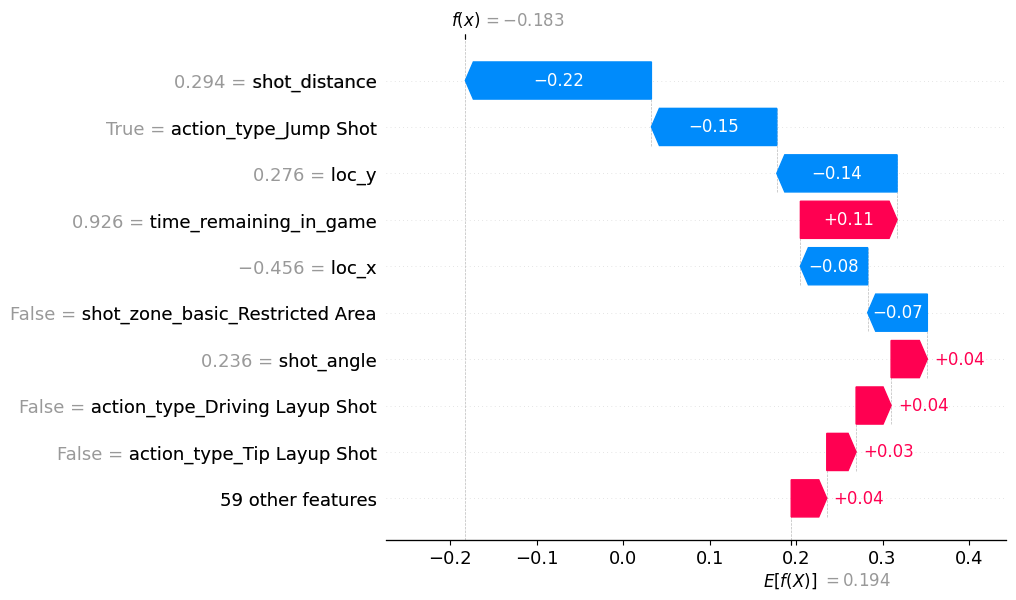

In [28]:
# Vamos escolher um arremesso específico para analisar.
# Por exemplo, o primeiro arremesso da nossa amostra.
instance_index = 69

# Gerar o gráfico de cascata para a primeira instância
shap.waterfall_plot(shap.Explanation(
    values=shap_values[instance_index],
    base_values=explainer.expected_value,
    data=X_test_sample.iloc[instance_index],
    feature_names=X_test_sample.columns.tolist()
))

# Salvando modelo

In [29]:
import joblib

# Defina um nome para o arquivo
model_filename_joblib = '../models/xgb_best_model.joblib'

# Use a função joblib.dump()
joblib.dump(best_model, model_filename_joblib)

print(f"Modelo salvo com sucesso em: {model_filename_joblib}")

Modelo salvo com sucesso em: ../models/xgb_best_model.joblib


In [30]:
X_test.to_csv('../data/X_test.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)